# Libraries

In [ ]:
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import wandb

In [ ]:
# device = ("cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(f"Using {device} device")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device.type} device")

Using cuda device


# Download the data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
# Upload the "kaggle.json" file
files.upload()

In [ ]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# remove the file from wd
! rm kaggle.json

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Check of the file is in the folder
!ls -a ~/.kaggle/
# ! ls ../content

.  ..  kaggle.json


In [ ]:
# Download Data: !kaggle competitions download -c "name-of-competition"
! kaggle competitions download -c "nlp-getting-started"

100% 593k/593k [00:00<00:00, 756kB/s]
100% 593k/593k [00:00<00:00, 756kB/s]


In [ ]:
# Create a directory named train,
! mkdir data

# unzip train data there,
! unzip nlp-getting-started.zip -d data
! rm nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


# Data

## Import data

In [ ]:
df_train_val = pd.read_csv("./data/train.csv")
df_train_val.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Convert "NaN" to ""Unknown""
df_train_val["keyword"].fillna("Unknown", inplace=True)
df_train_val.head()

,id,keyword,location,text,target
0,1,Unknown,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,Unknown,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,Unknown,NaN,All residents asked to 'shelter in place' are ...,1
3,6,Unknown,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,Unknown,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Vocabulary

In [ ]:
def yield_tokens(data):
    for k in data["keyword"]:
        yield [k]

vocab = build_vocab_from_iterator(yield_tokens(df_train_val), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

## Tokenizer

In [ ]:
tokenizer = get_tokenizer("basic_english")
text_pipeline = lambda x: vocab(tokenizer(x))

## Split train val

In [ ]:
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.2,
    random_state=42,
    shuffle=True)

print(df_train_val.shape)
print(df_train.shape)
print(df_val.shape)

(7613, 5)
(6090, 5)
(1523, 5)


In [ ]:
# df_train.reset_index(drop=True, inplace=True)
# df_val.reset_index(drop=True, inplace=True)

## Dataset class

In [ ]:
class TweetDisDataset(Dataset):

    def __init__(self, dataset, vocab, tokenizer):
      self.keyword = dataset["keyword"]
      self.target = dataset["target"]
      self.vocab = vocab
      self.tokenizer = tokenizer

    def __len__(self):
      return len(self.target)

    def __getitem__(self, idx):
      keyword_list = self.keyword.iloc[idx]
      keyword = [text_pipeline(token)[0] for token in [keyword_list]]
      target = self.target.iloc[idx]
      sample = {"keyword": keyword[0], "target": target}

      return sample

# Weights and Biases

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Define the Sweep

In [ ]:
sweep_config = {
    "method": "random"
}

metric = {
    "name": "loss",
    "goal": "minimize"
}
sweep_config["metric"] = metric

parameters_dict = {
    "epochs": {"value": 6},
    "batch_size": {"value": 128},
    # "n_layer": {"values": [1, 2]}
    "n_units": {"values": [64, 32, 16, 8]},
    "emb_dim": {"values": [64, 128, 256]},
    }

sweep_config["parameters"] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="disaster_tweets")

Create sweep with ID: 8c0azo25
Sweep URL: https://wandb.ai/daniele-didino/disaster_tweets/sweeps/8c0azo25


## Classes for model and training


In [ ]:
len(vocab.get_itos())

223

In [ ]:
vocab_size = vocab.__len__() # 223
embedding_dim = 128

In [ ]:
class EmbDenseModel(torch.nn.Module):

  def __init__(self, vocab_size, embedding_dim, n_units):
    super().__init__()
    torch.manual_seed(54321)
    lin1_units = n_units
    lin2_units = int(n_units/2)
    # vocab_size: size of the dictionary of embeddings
    # embedding_dim: size of embedding vector
    self.emb_layer = torch.nn.Embedding(vocab_size, embedding_dim)
    self.lin1 = torch.nn.Linear(embedding_dim, lin1_units)
    self.lin2 = torch.nn.Linear(lin1_units, lin2_units)
    self.lin3 = torch.nn.Linear(lin2_units, 1)
    #
    self.relu1 = torch.nn.ReLU()
    self.relu2 = torch.nn.ReLU()

  def forward(self, x):
    x = self.emb_layer(x)
    x = self.lin1(x)
    x = self.relu1(x) # x = torch.nn.functional.relu(x)
    x = self.lin2(x)
    x = self.relu2(x) # x = torch.nn.functional.relu(x)
    x = self.lin3(x)
    x = torch.nn.functional.sigmoid(x)
    return x

In [ ]:
def build_dataset(batch_size):
  train_dataset = TweetDisDataset(df_train, vocab, tokenizer)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  val_dataset = TweetDisDataset(df_val, vocab, tokenizer)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  return train_dataloader, val_dataloader


In [ ]:
def train_epoch(model, loader, optimizer, loss_fn):
  # Training phase
  model.train()
  running_loss = 0.0

  running_acc = 0
  for data in loader:

    # Get data
    keywords = data["keyword"]
    labels = data["target"]

    # Move inputs and labels to the device
    keywords = keywords.to(device)
    labels = labels.to(device)

    # Clear the gradients (because gradients are accumulated)
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(keywords)
    labels = labels.unsqueeze(1)
    labels = labels.float()

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather loss
    running_loss += loss.item()

    # Gather accuracy
    equals = torch.Tensor.round(outputs) == labels
    equals = equals.to(torch.float)
    equals = torch.sum(equals)
    running_acc += equals

  # Store loss
  train_loss = running_loss / len(loader.dataset)

  # Store accuracy
  train_acc = running_acc / len(loader.dataset)

  return train_loss, train_acc


In [ ]:
def val_epoch(model, loader, loss_fn):
  model.eval() # Set the model to evaluation mode
  running_vloss = 0.0

  # Disable gradient computation and reduce memory consumption
  with torch.no_grad():
    running_acc = 0
    for vdata in loader:

      # Get data
      keywords = vdata["keyword"]
      labels = vdata["target"]

      # Move inputs and labels to the device
      keywords = keywords.to(device)
      labels = labels.to(device)

      # Make predictions for this batch
      outputs = model(keywords)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      # Compute the loss and its gradients
      loss = loss_fn(outputs, labels)

      # Gather loss and accuracy
      running_vloss += loss.item()

      # Gather accuracy
      equals = torch.Tensor.round(outputs) == labels
      equals = equals.to(torch.float)
      equals = torch.sum(equals)
      running_acc += equals

  # Store loss
  val_loss = running_vloss / len(loader.dataset)

  # Store accuracy
  val_acc = running_acc / len(loader.dataset)

  return val_loss, val_acc

In [ ]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        config = wandb.config
        # Create data loaders
        train_dataloader, val_dataloader = build_dataset(config.batch_size)
        # Create model
        model = EmbDenseModel(vocab_size, config.emb_dim, config.n_units)
        model.to(device)
        # Loss function: Binary Cross Entropy
        loss_fn = torch.nn.BCELoss()
        # Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        for epoch in range(config.epochs):
          # Training phase
          train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, loss_fn)
          # Validation phase
          val_loss, val_acc = val_epoch(model, val_dataloader, loss_fn)
          wandb.log({
              "loss": train_loss,
              "train_acc": train_acc,
              "val_loss": val_loss,
              "val_acc": val_acc,
              "epoch": epoch})

## Training

In [ ]:
wandb.agent(sweep_id, train, count=20)

# Retrain best model

In [ ]:
BATCH_SIZE = 128
EMB_DIM = 128
EPOCHS = 2
N_UNITS = 64

train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []

train_dataloader, val_dataloader = build_dataset(BATCH_SIZE)
# Create model
model = EmbDenseModel(vocab_size, EMB_DIM, N_UNITS)
model.to(device)
# Loss function: Binary Cross Entropy
loss_fn = torch.nn.BCELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
  # Training phase
  train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, loss_fn)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc.cpu().numpy())
  # Validation phase
  val_loss, val_acc = val_epoch(model, val_dataloader, loss_fn)
  val_losses.append(val_loss)
  val_accuracy.append(val_acc.cpu().numpy())

  log_1 = f"Epoch {epoch+1}/{EPOCHS}"
  log_2 = f" - Train: loss = {train_loss:.5f};  acc = {train_acc:.3f}"
  log_3 = f" - Val: loss = {val_loss:.5f};  acc = {val_acc:.3f}"
  print(log_1 + log_2 + log_3)


Epoch 1/2 - Train: loss = 0.00520;  acc = 0.601 - Val: loss = 0.00497;  acc = 0.667
Epoch 2/2 - Train: loss = 0.00452;  acc = 0.724 - Val: loss = 0.00461;  acc = 0.720


# Loss & accuracy

In [ ]:
train_accuracy[1].cpu().numpy() #.tonumpy()

array(0.7238095, dtype=float32)

In [ ]:
def render_history(train_losses, val_losses, train_acc, val_acc):
  plt.figure(figsize=(10, 3))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Training loss")
  plt.plot(val_losses, label="Validation loss")
  plt.ylabel("Loss")
  plt.legend(frameon=False)
  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label="Training Accuracy")
  plt.plot(val_acc, label="Validation Accuracy")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

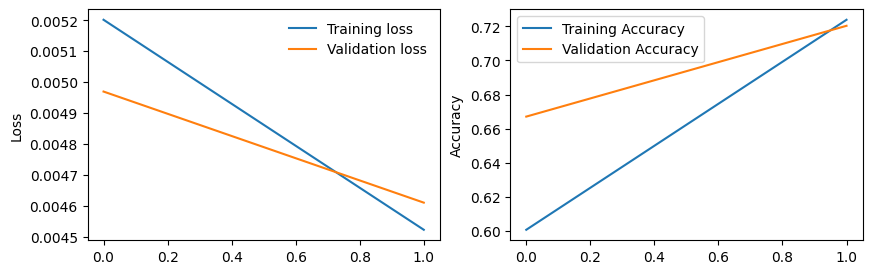

In [ ]:
render_history(train_losses, val_losses, train_accuracy, val_accuracy)

In [ ]:
def calc_acc(df):

  model.eval()

  X = [text_pipeline(k) for k in df["keyword"]]
  X = torch.tensor(X)
  X = X.to(device)
  X = X.squeeze()

  y_pred = model(X.squeeze())
  y_pred = y_pred.squeeze().numpy(force=True)
  y_pred = np.round(y_pred)

  y = [t for t in df["target"]]

  acc = y_pred == y
  f1 = f1_score(y, y_pred)

  return {"accuracy": acc.mean().round(3), "f1": f1.round(3)}

In [ ]:
calc_acc(df_train)

{'accuracy': 0.749, 'f1': 0.706}

In [ ]:
calc_acc(df_val)

{'accuracy': 0.72, 'f1': 0.677}

# Test set

For Kaggle submission

In [ ]:
df_test = pd.read_csv("./data/test.csv")
df_test["keyword"].fillna("Unknown", inplace=True)

df_test.head()

,id,keyword,location,text
0,0,Unknown,NaN,Just happened a terrible car crash
1,2,Unknown,NaN,"Heard about #earthquake is different cities, s..."
2,3,Unknown,NaN,"there is a forest fire at spot pond, geese are..."
3,9,Unknown,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,Unknown,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
X_test = [text_pipeline(k) for k in df_test["keyword"]]
X_test = torch.tensor(X_test)
X_test = X_test.to(device)
X_test = X_test.squeeze()
y_test_pred = model(X_test.squeeze())
y_test_pred = y_test_pred.squeeze().numpy(force=True)
y_test_pred = y_test_pred.round()
y_test_pred

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
df_submission_1 = pd.DataFrame({
    "id": df_test.id,
    "target": y_test_pred.astype(int)
})

df_submission_1.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
df_submission_1.to_csv("./data/test_submission_1.csv", index=False)